# Thực hành về nhà: Mô hình sinh DCGAN

In [2]:
!pip install torchsummary

In [4]:
!nvidia-smi
# from google.colab import drive
# drive.mount('/content/drive')

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import glob
import cv2
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms

from torch.nn import CrossEntropyLoss, Dropout, Softmax, Linear, Conv2d, LayerNorm
import matplotlib.pyplot as plt
from torchsummary import summary

Tue Sep 24 16:25:34 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   45C    P8             10W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
width = 28
height = 28
channels = 1

<H2>1. Load dữ liệu MNIST</H2>


In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

batch_size = 32

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 36491753.18it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1041660.09it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 9400461.60it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5147400.37it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



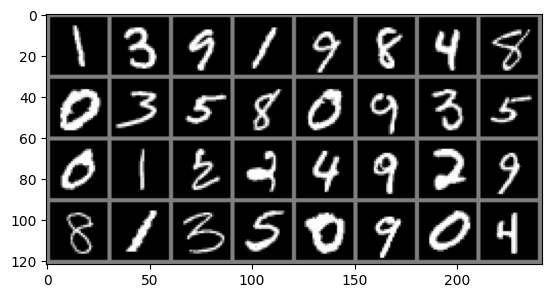

    1     3     9     1     9     8     4     8     0     3     5     8     0     9     3     5     0     1     2     2     4     9     2     9     8     1     3     5     0     9     0     4


In [8]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % labels[j].item() for j in range(batch_size)))

<H2>2. Generator</H2>

Lập trình mạng generator. 
    
    + Đầu vào là vector ngẫu nhiên 100 chiều.
    + Đầu ra là một ảnh fake với giá trị pixel trong khoảng [-1, 1].

Các thông số của mạng như sau

- Dense(7*7*128, kernel_initializer='glorot_normal',input_shape=(inidim,)))
- LeakyReLU(0.2))
- Reshape( [7, 7, 128])
- UpSampling2D(size=(2, 2))
- Conv2D(64, (5, 5), padding='same', kernel_initializer='glorot_uniform')
- LeakyReLU(0.2)
- UpSampling2D(size=(2, 2))
- Conv2D(1, (5, 5), padding='same', kernel_initializer='glorot_uniform'))
- Activation('tanh')



In [22]:
class Generator(nn.Module):
    def __init__(self, indim=100):
        super().__init__()
        self.net = nn.Sequential(
            nn.LazyLinear(128*7*7),
            nn.LeakyReLU(0.2),
            nn.Unflatten(1, (128,7,7)),
            nn.Upsample(scale_factor=2),
            nn.LazyConv2d(64, kernel_size=5, padding=2),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.LazyConv2d(1, kernel_size=5, padding=2),
            nn.Tanh()
        )
    
    def forward(self, x):
        return self.net(x)
    


G = Generator().cuda()
summary(G, (100, ), batch_size=-1, device='cuda')
print("_____________________ Generator Created_____________________")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 6272]         633,472
         LeakyReLU-2                 [-1, 6272]               0
         Unflatten-3            [-1, 128, 7, 7]               0
          Upsample-4          [-1, 128, 14, 14]               0
            Conv2d-5           [-1, 64, 14, 14]         204,864
         LeakyReLU-6           [-1, 64, 14, 14]               0
          Upsample-7           [-1, 64, 28, 28]               0
            Conv2d-8            [-1, 1, 28, 28]           1,601
              Tanh-9            [-1, 1, 28, 28]               0
Total params: 839,937
Trainable params: 839,937
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.92
Params size (MB): 3.20
Estimated Total Size (MB): 4.13
-------------------------------------------

<H2>4. Discriminator</H2>

Khai báo mạng discriminator

    + Đầu vào là một ảnh 28x28
    + Đầu ra là một xác suất cho ta biết ảnh đấy là real hay fake với giá trị trong miền [0, 1]

Thông số của mạng như sau:

-  Conv2D(64, (5, 5), strides=(2, 2), padding= 'same',input_shape=shp)
-  LeakyReLU(0.2)
-  Dropout(dropout_rate)
-  Conv2D(128, (5, 5), strides=(2, 2), padding = 'same')
-  LeakyReLU(0.2)
-  Dropout(dropout_rate)
-  Flatten()
-  Dense(1,activation='sigmoid')

In [23]:
class Discriminator(nn.Module):
    def __init__(self, input_dim=28, dropout_rate=0.1):
        super().__init__()
        self.model = nn.Sequential(
            nn.LazyConv2d(64, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate),
            nn.LazyConv2d(128, kernel_size=5, stride=2, padding=2),
            nn.Dropout(dropout_rate),
            nn.Flatten(),
            nn.LazyLinear(1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)

D = Discriminator().cuda()
summary(D, (1, 28, 28), batch_size=-1, device='cuda')
print("____________________ Discriminator Created____________________")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           1,664
         LeakyReLU-2           [-1, 64, 14, 14]               0
           Dropout-3           [-1, 64, 14, 14]               0
            Conv2d-4            [-1, 128, 7, 7]         204,928
           Dropout-5            [-1, 128, 7, 7]               0
           Flatten-6                 [-1, 6272]               0
            Linear-7                    [-1, 1]           6,273
           Sigmoid-8                    [-1, 1]               0
Total params: 212,865
Trainable params: 212,865
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.43
Params size (MB): 0.81
Estimated Total Size (MB): 1.25
----------------------------------------------------------------
____________________ Discriminator Created

<h2>5. GAN model</h2>

Chúng ta ghép hai mạng vào với nhau mang generator trước, mạng disciminator sau

Lập trình hàm để ghép mạng

In [24]:
class DCGAN(nn.Module):
    def __init__(self):
        super().__init__()
        self.G = Generator()
        self.D = Discriminator()
    
    def forward(self, x):
        fake = self.G(x)
        out = self.D(fake)
        return out

losses_G = []
losses_D = []
samples = []
optimizer_G = optim.Adam(G.parameters(), lr=0.0001, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=0.0001, betas=(0.5, 0.999))
criterion = nn.BCELoss()

In [25]:
epochs=100
for epoch in range(epochs):
    for (i, (imgs, _)) in enumerate(trainloader, start=1):
        # Adversarial ground truths
        valid = Variable(torch.cuda.FloatTensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(torch.cuda.FloatTensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(torch.cuda.FloatTensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(torch.cuda.FloatTensor(np.random.normal(0, 1, (imgs.shape[0], 100))))

        # Generate a batch of images
        gen_imgs = G(z)

        # Loss measures generator's ability to fool the discriminator
        
        out = D(gen_imgs)
        g_loss = criterion(out, valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Loss measures discriminator's ability to classify real from generated samples
        out2 = D(real_imgs)
        real_loss = criterion(out2, valid)
        fake_loss = criterion(D(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss)/2
        d_loss.backward()
        optimizer_D.step()

        if epoch % 10 == 0 and i == len(trainloader):
            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch, epochs, i, len(trainloader), d_loss.item(), g_loss.item())
            )
            
            losses_G.append(g_loss.item())
            losses_D.append(d_loss.item())
            samples.append(gen_imgs)


[Epoch 0/100] [Batch 1875/1875] [D loss: 0.000023] [G loss: 10.127624]
[Epoch 10/100] [Batch 1875/1875] [D loss: 0.000000] [G loss: 18.858152]
[Epoch 20/100] [Batch 1875/1875] [D loss: 0.000000] [G loss: 25.258648]
[Epoch 30/100] [Batch 1875/1875] [D loss: 0.000000] [G loss: 26.909767]
[Epoch 40/100] [Batch 1875/1875] [D loss: 0.000000] [G loss: 27.438358]
[Epoch 50/100] [Batch 1875/1875] [D loss: 0.000000] [G loss: 27.677818]
[Epoch 60/100] [Batch 1875/1875] [D loss: 0.000000] [G loss: 27.768990]
[Epoch 70/100] [Batch 1875/1875] [D loss: 0.000000] [G loss: 27.828613]
[Epoch 80/100] [Batch 1875/1875] [D loss: 0.000000] [G loss: 28.180767]
[Epoch 90/100] [Batch 1875/1875] [D loss: 0.000000] [G loss: 26.972420]


### Vẽ đồ thị loss khi huấn luyện

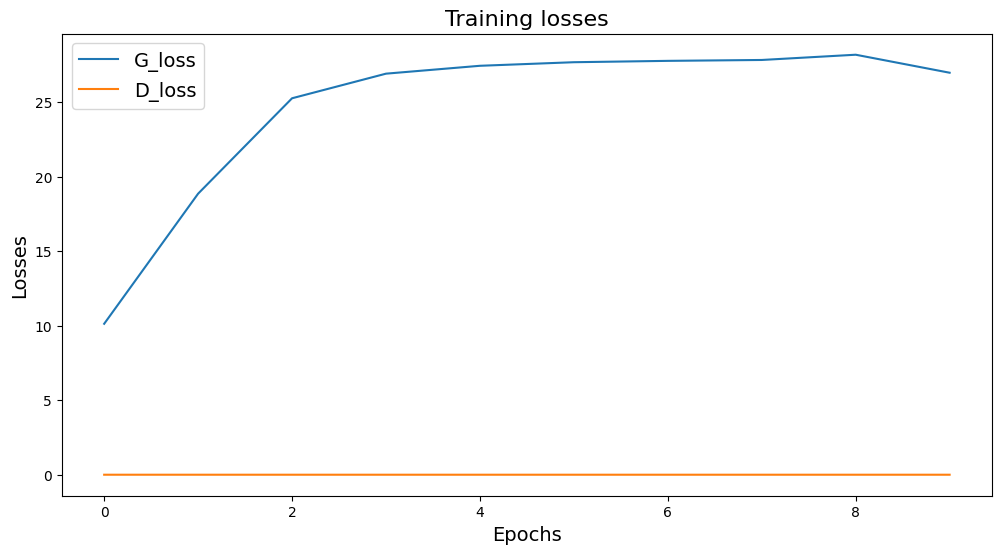

In [28]:
plt.figure(figsize=(12, 6))
plt.plot(list(range(int(len(losses_G)/10)*10)), losses_G, label="G_loss")
plt.plot(list(range(int(len(losses_D)/10)*10)), losses_D, label="D_loss")
plt.title("Training losses", fontsize=16)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Losses", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.show()

### Trực quan dữ liệu sinh ra thử mạng học được

    ____________________ Step = 0 ____________________


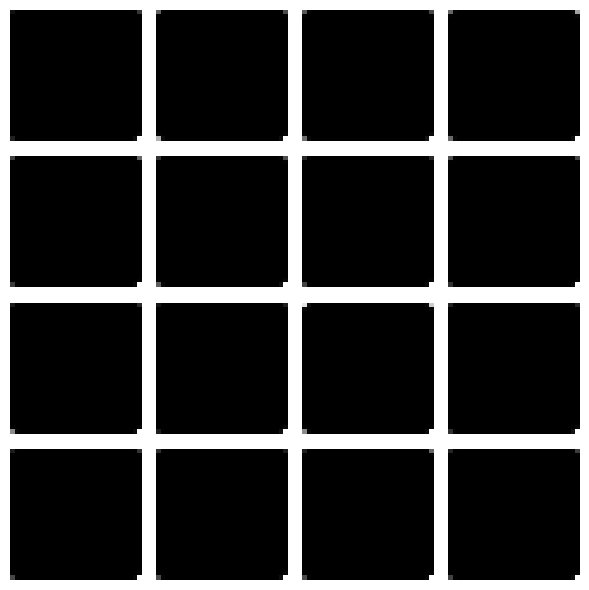

In [29]:
i = 0
for i in range(0, len(samples), 10):
    images = samples[i].data.cpu().numpy()
    print("    ____________________ Step = %d ____________________" % i)
    plt.figure(figsize=(6, 6))
    for i in range(16):
        plt.subplot(4, 4, i+1)
        image = images[i, :, :, :]
        image = np.reshape(image, [height, width])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    print("\n")